In [1]:
# import dependencies
import matplotlib.pyplot as plt
import numpy as np
import probtorch
import scipy.io as sio
import scipy.optimize
import time
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch.nn import Parameter

%matplotlib inline

In [2]:
# check the availability of CUDA
CUDA = torch.cuda.is_available()

In [3]:
# placeholder values for hyperparameters
LEARNING_RATE = 1e-4
NUM_FACTORS   = 50
NUM_SAMPLES   = 10
SOURCE_WEIGHT_STD_DEV = np.sqrt(2.0)
SOURCE_LOG_WIDTH_STD_DEV  = np.sqrt(3.0)
VOXEL_NOISE            = 0.1

We here set some manually calibrated hyperparameter values.  In particular, ProbTorch uses standard deviations (σ) for its Normal distributions instead of variances (σ^2).

In [4]:
# locations: V x 3
# centers: S x K x 3
# log_widths: S x K
def radial_basis(locations, centers, log_widths, num_voxels, num_samples=NUM_SAMPLES):
    # V x 3 -> S x 1 x V x 3
    locations = locations.expand(num_samples, num_voxels, 3).unsqueeze(1)
    # S x K x 3 -> S x K x 1 x 3  
    centers = centers.unsqueeze(2)
    # S x K x V x 3
    delta2s = (locations - centers)**2
    # S x K  -> S x K x 1
    log_widths = log_widths.unsqueeze(2)
    return torch.exp(-delta2s.sum(3) / torch.exp(log_widths))

def free_energy(q, p, num_samples=NUM_SAMPLES):
    # Remember: the Evidence Lower Bound is the negative free-energy
    return -probtorch.objectives.montecarlo.elbo(q, p, sample_dim=0)

def kl_divergence(q, p, num_samples=NUM_SAMPLES):
    return probtorch.objectives.montecarlo.kl(q, p, sample_dim=0)

We set up the radial basis functions so that the dimensions match up correctly and the math is as clear as possible, using elementwise tensor math everywhere.  Torch optimizers also seem to only minimize, so we negate the ELBO objective and call it the free-energy.

The other objective functions are to check the noise and calibration on our optimization.

In [5]:
class TFAEncoder(nn.Module):
    def __init__(self, num_times, num_factors=NUM_FACTORS):
        super(self.__class__, self).__init__()
        self._num_times = num_times
        self._num_factors = num_factors
        
        self._mean_weight = Parameter(torch.randn((self._num_times, self._num_factors)))
        self._weight_std_dev = Parameter(torch.sqrt(torch.rand((self._num_times, self._num_factors))))
        
        self._mean_factor_center = Parameter(torch.randn((self._num_factors, 3)))
        self._factor_center_std_dev = Parameter(torch.sqrt(torch.rand((self._num_factors, 3))))
        
        self._mean_factor_log_width = Parameter(torch.randn((self._num_factors)))
        self._factor_log_width_std_dev = Parameter(torch.sqrt(torch.rand((self._num_factors))))

    def forward(self, num_samples = NUM_SAMPLES):
        q = probtorch.Trace()

        mean_weight = self._mean_weight.expand(num_samples, self._num_times, self._num_factors)
        weight_std_dev = self._weight_std_dev.expand(num_samples, self._num_times, self._num_factors)
        
        mean_factor_center = self._mean_factor_center.expand(num_samples, self._num_factors, 3)
        factor_center_std_dev = self._factor_center_std_dev.expand(num_samples, self._num_factors, 3)
        
        mean_factor_log_width = self._mean_factor_log_width.expand(num_samples, self._num_factors)
        factor_log_width_std_dev = self._factor_log_width_std_dev.expand(num_samples, self._num_factors)
        
        weights = q.normal(mean_weight, weight_std_dev, name='Weights')
        
        factor_centers = q.normal(mean_factor_center, factor_center_std_dev, name='FactorCenters')
        factor_log_widths = q.normal(mean_factor_log_width, factor_log_width_std_dev, name='FactorLogWidths')
        
        return q

In [6]:
class TFADecoder(nn.Module):
    def __init__(self, brain_center, brain_center_std_dev, num_times, num_voxels, num_factors=NUM_FACTORS):
        super(self.__class__, self).__init__()
        self._num_times = num_times
        self._num_factors = num_factors
        self._num_voxels = num_voxels
        
        self._mean_weight = Variable(torch.zeros((self._num_times, self._num_factors)))
        self._weight_std_dev = Variable(SOURCE_WEIGHT_STD_DEV * torch.ones((self._num_times, self._num_factors)))
        
        self._mean_factor_center = Variable(brain_center.expand(self._num_factors, 3) * torch.ones((self._num_factors, 3)))
        self._factor_center_std_dev = Variable(brain_center_std_dev.expand(self._num_factors, 3) * torch.ones((self._num_factors, 3)))
        
        self._mean_factor_log_width = Variable(torch.ones((self._num_factors)))
        self._factor_log_width_std_dev = Variable(SOURCE_LOG_WIDTH_STD_DEV * torch.ones((self._num_factors)))
        
        self._voxel_noise = Variable(VOXEL_NOISE * torch.ones(self._num_times, self._num_voxels))
        
    def forward(self, activations, locations, q=None):
        p = probtorch.Trace()
        
        weights = p.normal(self._mean_weight, self._weight_std_dev, value=q['Weights'], name='Weights')
        factor_centers = p.normal(self._mean_factor_center, self._factor_center_std_dev, value=q['FactorCenters'], name='FactorCenters')
        factor_log_widths = p.normal(self._mean_factor_log_width, self._factor_log_width_std_dev, value=q['FactorLogWidths'], name='FactorLogWidths')
        factors = radial_basis(locations, factor_centers, factor_log_widths, num_voxels = self._num_voxels)
        observations = p.normal(torch.matmul(weights, factors), self._voxel_noise, value=activations, name='Y')
        
        return p

In [7]:
class TopographicalFactorAnalysis:
    def __init__(self, data_file):
        dataset = sio.loadmat(data_file)
        # pull out the voxel activations and locations
        self.voxel_activations = torch.Tensor(dataset['data']).transpose(0, 1)
        self.voxel_locations = torch.Tensor(dataset['R'])
        
        # This could be a huge file.  Close it
        del dataset
        
        # Pull out relevant dimensions: the number of times-of-recording, and the number of voxels in each timewise "slice"
        self.num_times = self.voxel_activations.shape[0]
        self.num_voxels = self.voxel_activations.shape[1]
        
        # Estimate further hyperparameters from the dataset
        self.brain_center = torch.mean(self.voxel_locations, 0).unsqueeze(0)
        self.brain_center_std_dev = torch.sqrt(10 * torch.var(self.voxel_locations, 0).unsqueeze(0))
        
        self.enc = TFAEncoder(self.num_times)
        self.dec = TFADecoder(self.brain_center, self.brain_center_std_dev, self.num_times, self.num_voxels)
        
        if CUDA:
            self.enc.cuda()
            self.dec.cuda()
        
    def train(self, num_steps=10):
        activations = Variable(self.voxel_activations)
        locations = Variable(self.voxel_locations)
        optimizer = torch.optim.Adam(list(self.enc.parameters()), lr=LEARNING_RATE)
        if CUDA:
            activations = activations.cuda()
            locations = locations.cuda()
        
        self.enc.train()
        self.dec.train()

        free_energies = np.zeros(num_steps)
        kls = np.zeros(num_steps)
        
        for n in range(num_steps):
            start = time.time()
            
            optimizer.zero_grad()
            q = self.enc()
            p = self.dec(activations=activations, locations=locations, q=q)
            
            free_energy_n = free_energy(q, p)
            kl = kl_divergence(q, p)
            
            free_energy_n.backward()
            optimizer.step()
            
            if CUDA:
                free_energy_n = free_energy_n.cpu()
                kl = kl.cpu()
            free_energies[n] = free_energy_n.data.numpy()[0]
            kls[n] = kl.data.numpy()[0]
            
            end = time.time()
            print('[Epoch %d] (%ds) Posterior free-energy %.8e, Joint KL divergence %.8e' % (n + 1, end - start, free_energy_n, kl))
        
        losses = np.vstack([free_energies, kls])
        return losses
    
    def results(self):
        q = self.enc()
        if CUDA:
            q['Weights'].value.data.cpu()
            q['FactorCenters'].value.data.cpu()
            q['FactorLogWidths'].value.data.cpu()
        
        weights = q['Weights'].value.data.numpy()
        factor_centers = q['FactorCenters'].value.data.numpy()
        factor_log_widths = q['FactorLogWidths'].value.data.numpy()
        
        return {'weights': weights, 'factor_centers': factor_centers, 'factor_log_widths': factor_log_widths}

In [8]:
tfa = TopographicalFactorAnalysis('s0.mat')
losses = tfa.train(num_steps=100)

[Epoch 1] (0s) Posterior free-energy 1.18691230e+07, Joint KL divergence 1.15946963e+04
[Epoch 2] (0s) Posterior free-energy 1.18691320e+07, Joint KL divergence 1.16039326e+04
[Epoch 3] (0s) Posterior free-energy 1.18691260e+07, Joint KL divergence 1.15978760e+04
[Epoch 4] (0s) Posterior free-energy 1.18690820e+07, Joint KL divergence 1.15544873e+04
[Epoch 5] (0s) Posterior free-energy 1.18691200e+07, Joint KL divergence 1.15919834e+04
[Epoch 6] (0s) Posterior free-energy 1.18691910e+07, Joint KL divergence 1.16633232e+04
[Epoch 7] (0s) Posterior free-energy 1.18691130e+07, Joint KL divergence 1.15845215e+04
[Epoch 8] (0s) Posterior free-energy 1.18691390e+07, Joint KL divergence 1.16111426e+04
[Epoch 9] (0s) Posterior free-energy 1.18690970e+07, Joint KL divergence 1.15694141e+04
[Epoch 10] (0s) Posterior free-energy 1.18691030e+07, Joint KL divergence 1.15754004e+04
[Epoch 11] (0s) Posterior free-energy 1.18690960e+07, Joint KL divergence 1.15676504e+04
[Epoch 12] (0s) Posterior free

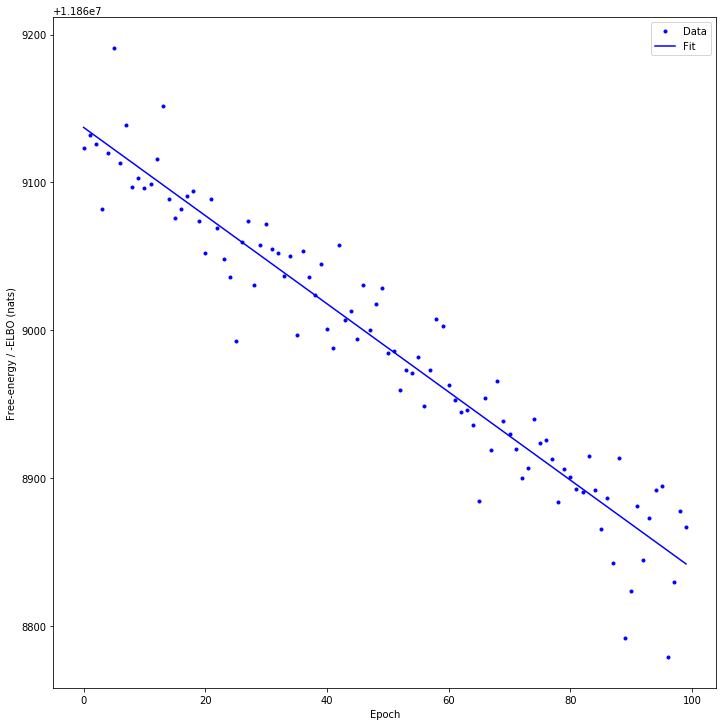

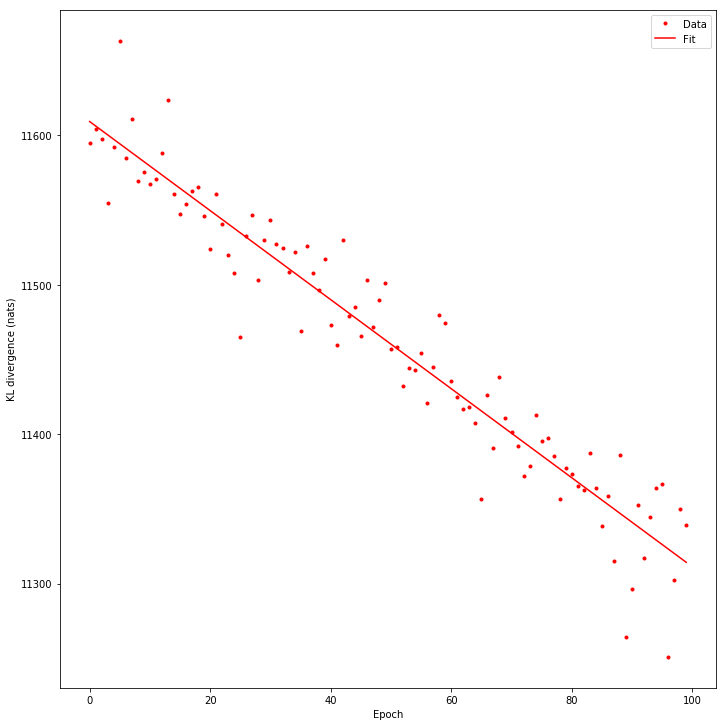

In [9]:
def linear(x, m, b):
     return m * x + b

epochs = range(losses.shape[1])
    
free_energy_fig = plt.figure(figsize=(10, 10))

plt.plot(epochs, losses[0,:], 'b.', label='Data')
parameters, pcov = scipy.optimize.curve_fit(linear, epochs, losses[0,:])
plt.plot(epochs, linear(epochs, *parameters), 'b', label="Fit");
plt.legend()

free_energy_fig.tight_layout()
free_energy_fig.axes[0].set_xlabel('Epoch')
free_energy_fig.axes[0].set_ylabel('Free-energy / -ELBO (nats)')

kl_fig = plt.figure(figsize=(10, 10))

plt.plot(epochs, losses[1,:], 'r.', label='Data')
parameters, pcov = scipy.optimize.curve_fit(linear, epochs, losses[1,:])
plt.plot(epochs, linear(epochs, *parameters), 'r', label="Fit");
plt.legend()

kl_fig.tight_layout()
kl_fig.axes[0].set_xlabel('Epoch')
kl_fig.axes[0].set_ylabel('KL divergence (nats)')

In [10]:
tfa.results()

{'factor_centers': array([[[-0.56723845,  1.48943138,  0.23322169],
         [-1.80151486,  0.8994875 ,  0.31715035],
         [ 3.45954704,  2.0791626 , -1.24126887],
         ..., 
         [ 1.40022016,  0.02371722,  0.6342051 ],
         [ 2.6013577 , -0.10262516, -2.16164351],
         [ 0.46714592, -0.40863755, -1.58586192]],
 
        [[-1.59358585, -0.33570868,  1.44035661],
         [-2.69551063, -0.58968019,  0.27547696],
         [ 3.24150825,  0.86745638, -1.26568675],
         ..., 
         [ 1.04895949,  0.03980854,  0.67422909],
         [ 2.8722682 ,  0.09350246, -1.01367879],
         [-0.44268551, -0.13777372, -1.98966134]],
 
        [[ 0.56262696,  2.44237947, -0.03470004],
         [-1.35941029, -0.34226489,  0.28255266],
         [ 3.82581449,  0.92355263, -1.12834215],
         ..., 
         [ 0.42885831, -0.17940167,  1.24871588],
         [ 2.30635214,  0.45785004, -1.2410574 ],
         [ 0.37992567,  0.16195045, -2.86859512]],
 
        ..., 
        [[-1.6